### Importing libraries

In [1]:
import re
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pytextrank
import nltk
from nltk.corpus import stopwords
from gensim import models, corpora
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

C:\Users\Aibhinav\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
survey_score=pd.read_csv('./Survey data_Inflight Satisfaction Score.csv');
print(survey_score.isnull().sum())

flight_number                           0
origin_station_code                     0
destination_station_code                0
record_locator                          0
scheduled_departure_date                0
question_text                           0
score                                   0
satisfaction_type                   12111
driver_sub_group1                       0
driver_sub_group2                       0
arrival_delay_minutes                   0
arrival_delay_group                     0
cabin_code_desc                         0
cabin_name                          19980
entity                                  3
number_of_legs                          0
seat_factor_band                        0
loyalty_program_level               11616
generation                              0
fleet_type_description                  0
fleet_usage                             0
equipment_type_code                     0
ua_uax                                  0
actual_flown_miles                

### We shall divide the dataframe on the basis of the question asked, i.e. Asking for the score or asking what item was chosen.

In [3]:
condition=(survey_score['driver_sub_group2']=='comp')
Entree_type_question=survey_score[condition].reset_index()
Total_satisfaction=survey_score[~condition].reset_index()

In [4]:
print(Entree_type_question)

       index  flight_number origin_station_code destination_station_code  \
0         82           1979                 SFX                      LAX   
1        272           1020                 CUX                      IAX   
2        278           3418                 EWX                      JAX   
3        281           3418                 EWX                      JAX   
4        285            296                 DEX                      GEX   
...      ...            ...                 ...                      ...   
12106  47064            189                 EWX                      JNX   
12107  47065            189                 EWX                      JNX   
12108  47068            188                 JNX                      EWX   
12109  47072              3                 SIX                      SFX   
12110  47073              2                 SFX                      SIX   

      record_locator scheduled_departure_date              question_text  \
0          

Text(0, 0.5, 'Count')

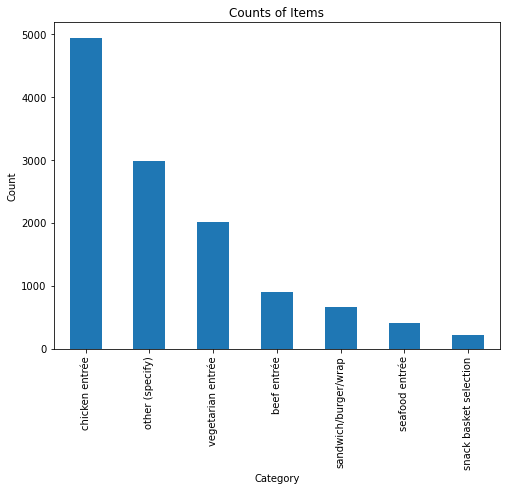

In [5]:
Items = Entree_type_question['score'].value_counts()
plt.figure(figsize=(8, 6))
Items.plot(kind='bar')
plt.title('Counts of Items')
plt.xlabel('Category')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

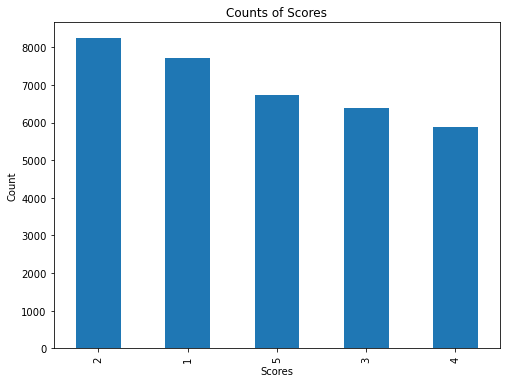

In [6]:
Ratings = Total_satisfaction['score'].value_counts()
plt.figure(figsize=(8, 6))
Ratings.plot(kind='bar')
plt.title('Counts of Scores')
plt.xlabel('Scores')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

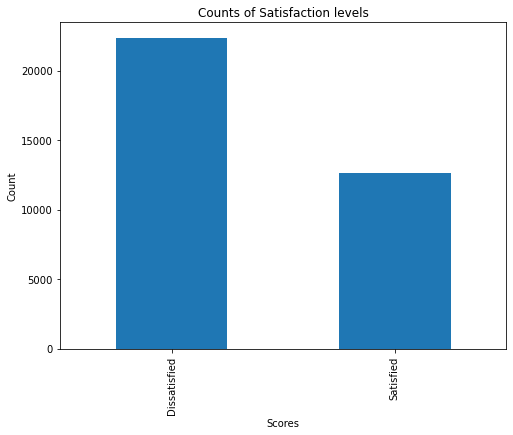

In [7]:
Satisfaction = Total_satisfaction['satisfaction_type'].value_counts()
plt.figure(figsize=(8, 6))
Satisfaction.plot(kind='bar')
plt.title('Counts of Satisfaction levels')
plt.xlabel('Scores')
plt.ylabel('Count')

### We can notice that the dissatisfaction levels are higher and are for range 1-3.

In [8]:
Entree_type_question['actual_score']=None
for row_ind in range(len(Entree_type_question)):
    id_value=Entree_type_question.loc[row_ind, 'record_locator']
    matching_row = Total_satisfaction[Total_satisfaction['record_locator'] == id_value]
    if not matching_row.empty:
        new_value = matching_row.iloc[0]['score']
        Entree_type_question.loc[row_ind, 'actual_score'] = new_value
Entree_type_question['actual_score']=Entree_type_question['actual_score'].astype(int)

In [9]:
print(Entree_type_question)

       index  flight_number origin_station_code destination_station_code  \
0         82           1979                 SFX                      LAX   
1        272           1020                 CUX                      IAX   
2        278           3418                 EWX                      JAX   
3        281           3418                 EWX                      JAX   
4        285            296                 DEX                      GEX   
...      ...            ...                 ...                      ...   
12106  47064            189                 EWX                      JNX   
12107  47065            189                 EWX                      JNX   
12108  47068            188                 JNX                      EWX   
12109  47072              3                 SIX                      SFX   
12110  47073              2                 SFX                      SIX   

      record_locator scheduled_departure_date              question_text  \
0          

### Now we have every type of Item with the rating provided by the Travellers for that item

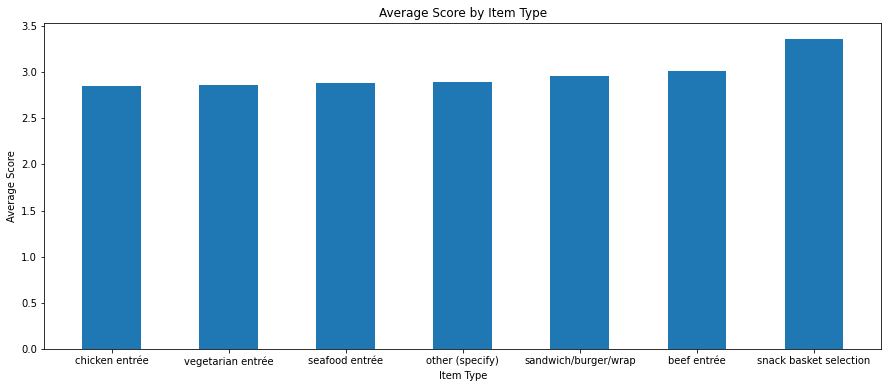

In [10]:
Entree_type_question['actual_score']=Entree_type_question['actual_score'].astype(int)
Entree_type_question = Entree_type_question.rename(columns={'score': 'food_type'})
average_score_byitem = Entree_type_question.groupby('food_type')['actual_score'].mean().reset_index()
average_score_byitem = average_score_byitem.sort_values(by='actual_score')
plt.figure(figsize=(15, 6))
plt.bar(average_score_byitem['food_type'], average_score_byitem['actual_score'],width=.5)
plt.xlabel('Item Type')
plt.ylabel('Average Score')
plt.title('Average Score by Item Type')
plt.show()

### - We can notice that snack basket collection is the one with the most positive score overall followed by beef entree, chicken entree remains the least.
### - Thus it might be better to contain more stock of snack basket collection and recommend it more to the travellers.

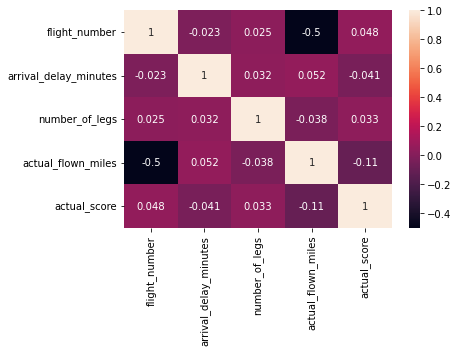

In [11]:
selected_cols=['flight_number','arrival_delay_minutes','number_of_legs','actual_flown_miles','actual_score']
num_data=Entree_type_question[selected_cols]
sns.heatmap(num_data.corr(), annot=True)
plt.show()


### - We can see that the late arrival delay can also cause dissatisfaction with the score.
### - Another evaluation that can be done is that their is a negative correlation between the score provided and the amount of distance travelled. This shall be analyzed further.

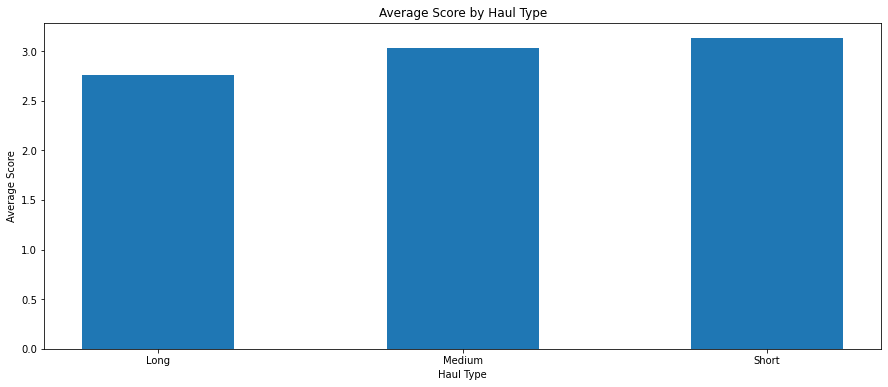

In [12]:
average_score_byhaul = Entree_type_question.groupby('haul_type')['actual_score'].mean().reset_index()
average_score_byhaul = average_score_byhaul.sort_values(by='actual_score')
plt.figure(figsize=(15, 6))
plt.bar(average_score_byhaul['haul_type'], average_score_byhaul['actual_score'],width=.5)
plt.xlabel('Haul Type')
plt.ylabel('Average Score')
plt.title('Average Score by Haul Type')
plt.show()

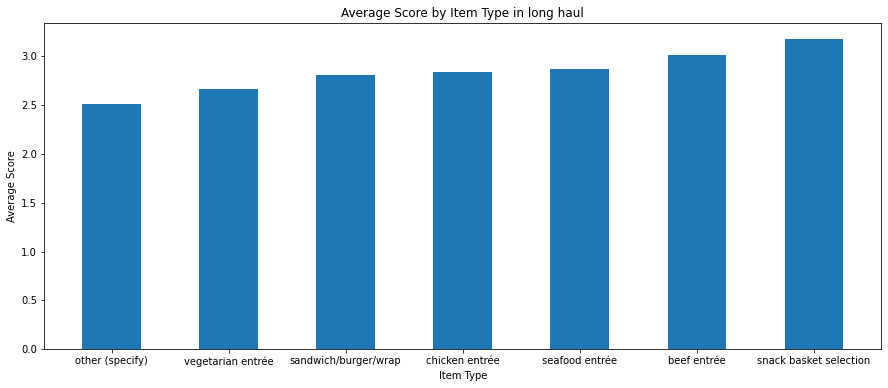

In [13]:
#We can also notice that as the haul gets larger the average scores decrease.
#Also lets look into which type of food on different hauls is giving better scores.
long_haul_score=Entree_type_question[Entree_type_question['haul_type']=='Long']
average_score_byitem = long_haul_score.groupby('food_type')['actual_score'].mean().reset_index()
average_score_byitem = average_score_byitem.sort_values(by='actual_score')
plt.figure(figsize=(15, 6))
plt.bar(average_score_byitem['food_type'], average_score_byitem['actual_score'],width=.5)
plt.xlabel('Item Type')
plt.ylabel('Average Score')
plt.title('Average Score by Item Type in long haul')
plt.show()

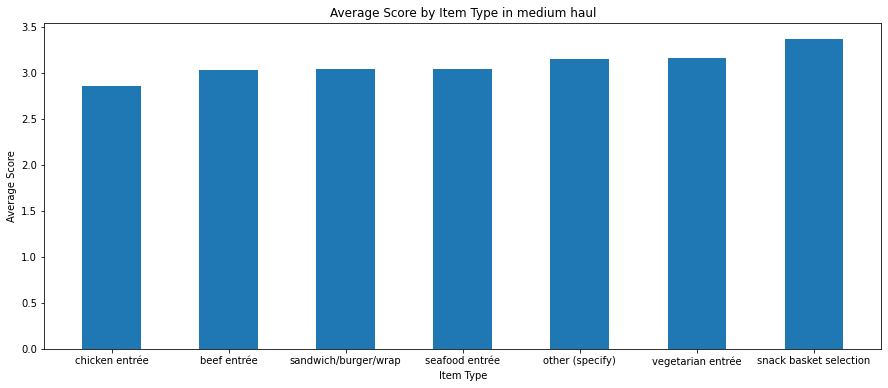

In [14]:
medium_haul_score=Entree_type_question[Entree_type_question['haul_type']=='Medium']
average_score_byitem = medium_haul_score.groupby('food_type')['actual_score'].mean().reset_index()
average_score_byitem = average_score_byitem.sort_values(by='actual_score')
plt.figure(figsize=(15, 6))
plt.bar(average_score_byitem['food_type'], average_score_byitem['actual_score'],width=.5)
plt.xlabel('Item Type')
plt.ylabel('Average Score')
plt.title('Average Score by Item Type in medium haul')
plt.show()

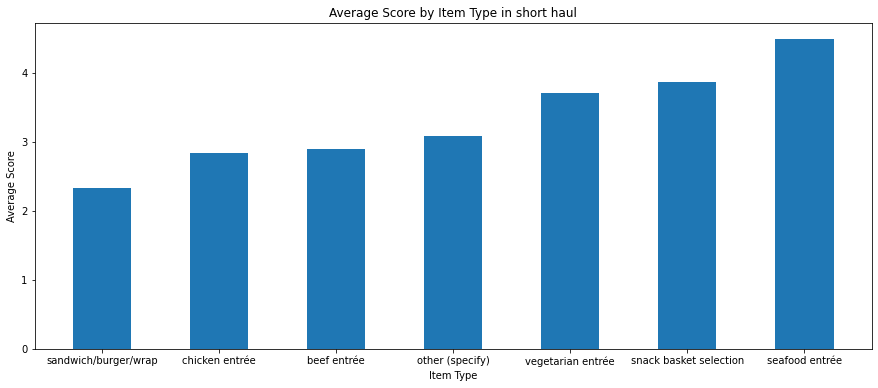

In [15]:
short_haul_score=Entree_type_question[Entree_type_question['haul_type']=='Short']
average_score_byitem = short_haul_score.groupby('food_type')['actual_score'].mean().reset_index()
average_score_byitem = average_score_byitem.sort_values(by='actual_score')
plt.figure(figsize=(15, 6))
plt.bar(average_score_byitem['food_type'], average_score_byitem['actual_score'],width=.5)
plt.xlabel('Item Type')
plt.ylabel('Average Score')
plt.title('Average Score by Item Type in short haul')
plt.show()

### - As we can see Seafood has much higher scores for short hauls as although it may be a bit costly and less filling but it is a bit more richer,
### - Snack basket is better on Medium and long hauls with chicken entree performing much better in long hauls and veg on medium.
### - As a strategy we can remove the least performing items on each type of hauls and make up in its inventory for higher performing items on the Flight.
### We can now look into the inventory dataset.

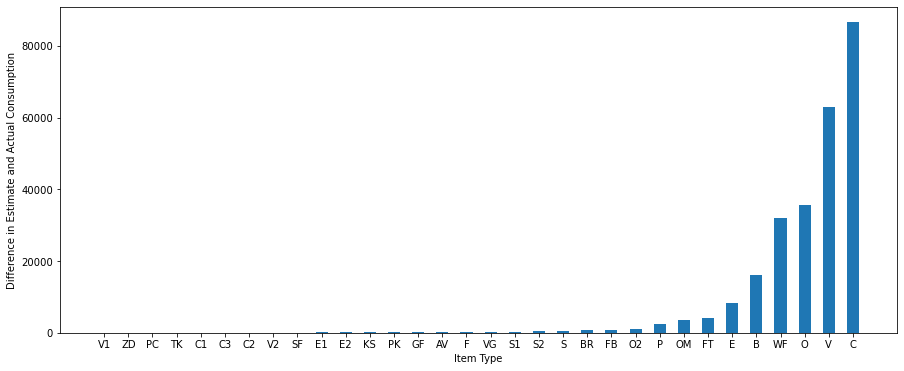

In [16]:
inventory=pd.read_csv('./Inflight Service_Inventory data.csv')
inventory['Difference']=inventory['planned_entree_count']-inventory['consumed_entree_count']
consume_diff=inventory.groupby('entree_code')['Difference'].sum().reset_index()
consume_diff = consume_diff.sort_values(by='Difference')
plt.figure(figsize=(15, 6))
plt.bar(consume_diff['entree_code'], consume_diff['Difference'],width=.5)
plt.xlabel('Item Type')
plt.ylabel('Difference in Estimate and Actual Consumption')
plt.title('')
plt.show()

### We can see that the items with code V and C are left with a high amount and the estimation is not performing upto the mark. We shall try to check which specific items are causing this to occur.

In [17]:
c_code_inventory=inventory[inventory['entree_code']=='C']
v_code_inventory=inventory[inventory['entree_code']=='V']

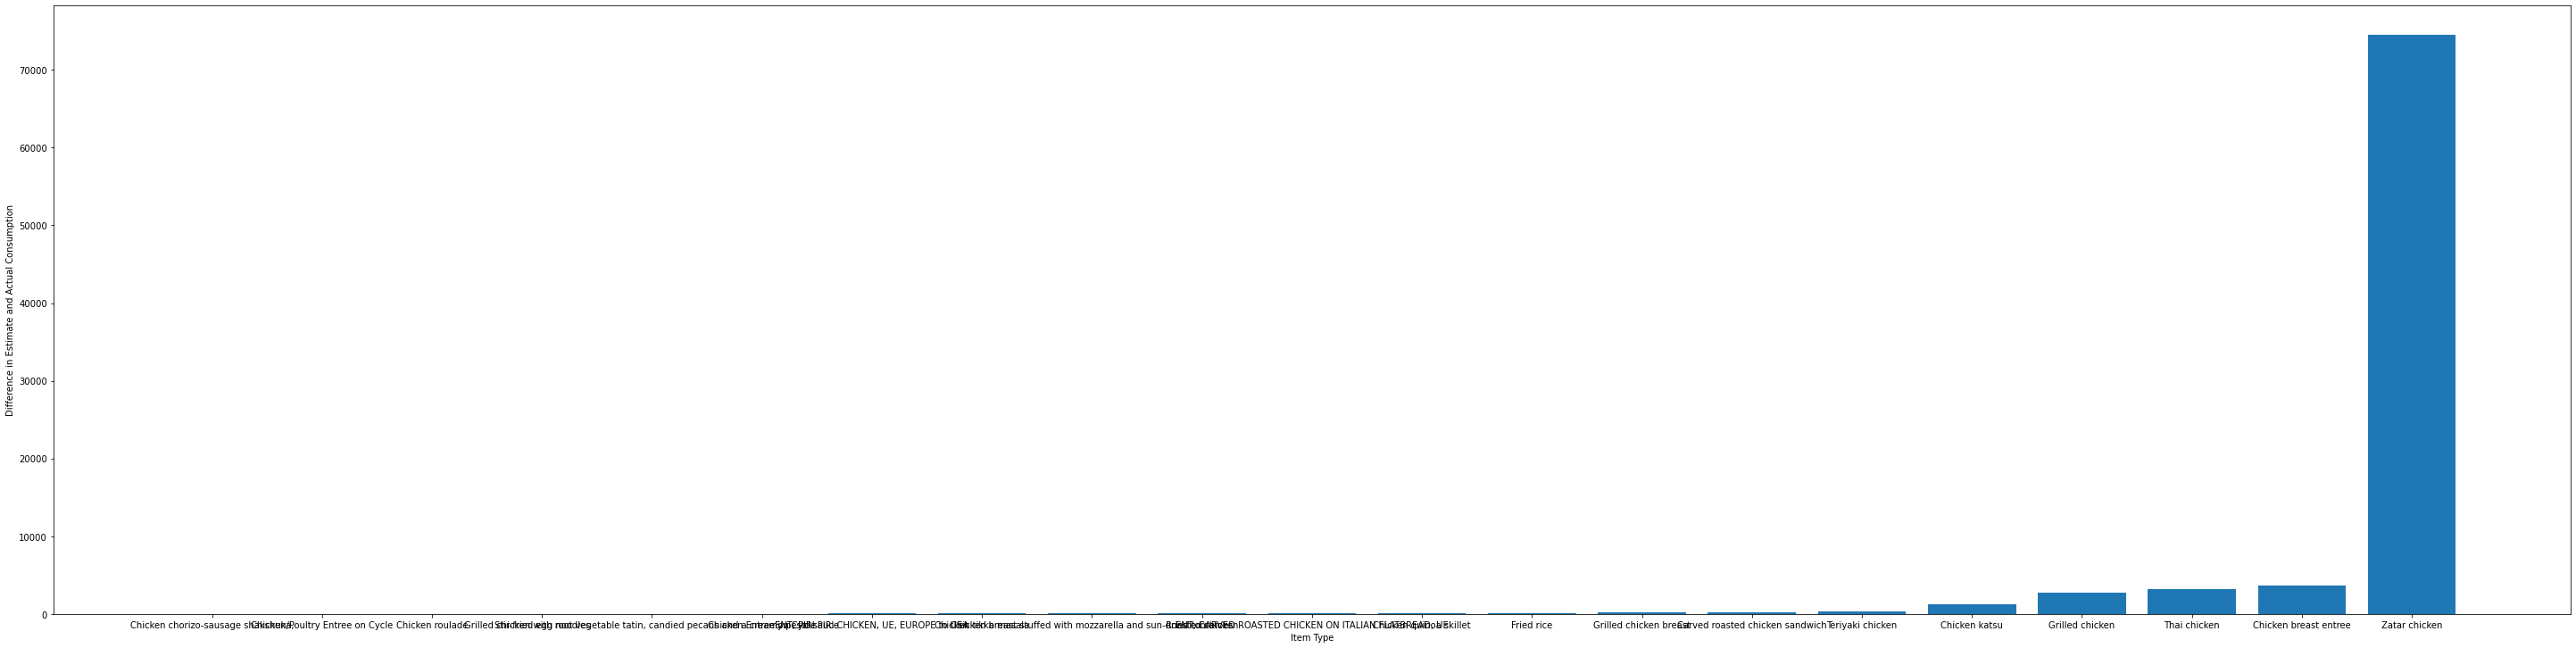

In [18]:
c_code_inventory=c_code_inventory.groupby('entree_description')['Difference'].sum().reset_index()
c_code_inventory = c_code_inventory.sort_values(by='Difference')
plt.figure(figsize=(40, 10))
plt.bar(c_code_inventory['entree_description'], c_code_inventory['Difference'])
plt.tight_layout()
plt.xlabel('Item Type')
plt.ylabel('Difference in Estimate and Actual Consumption')
plt.title('')
plt.show()

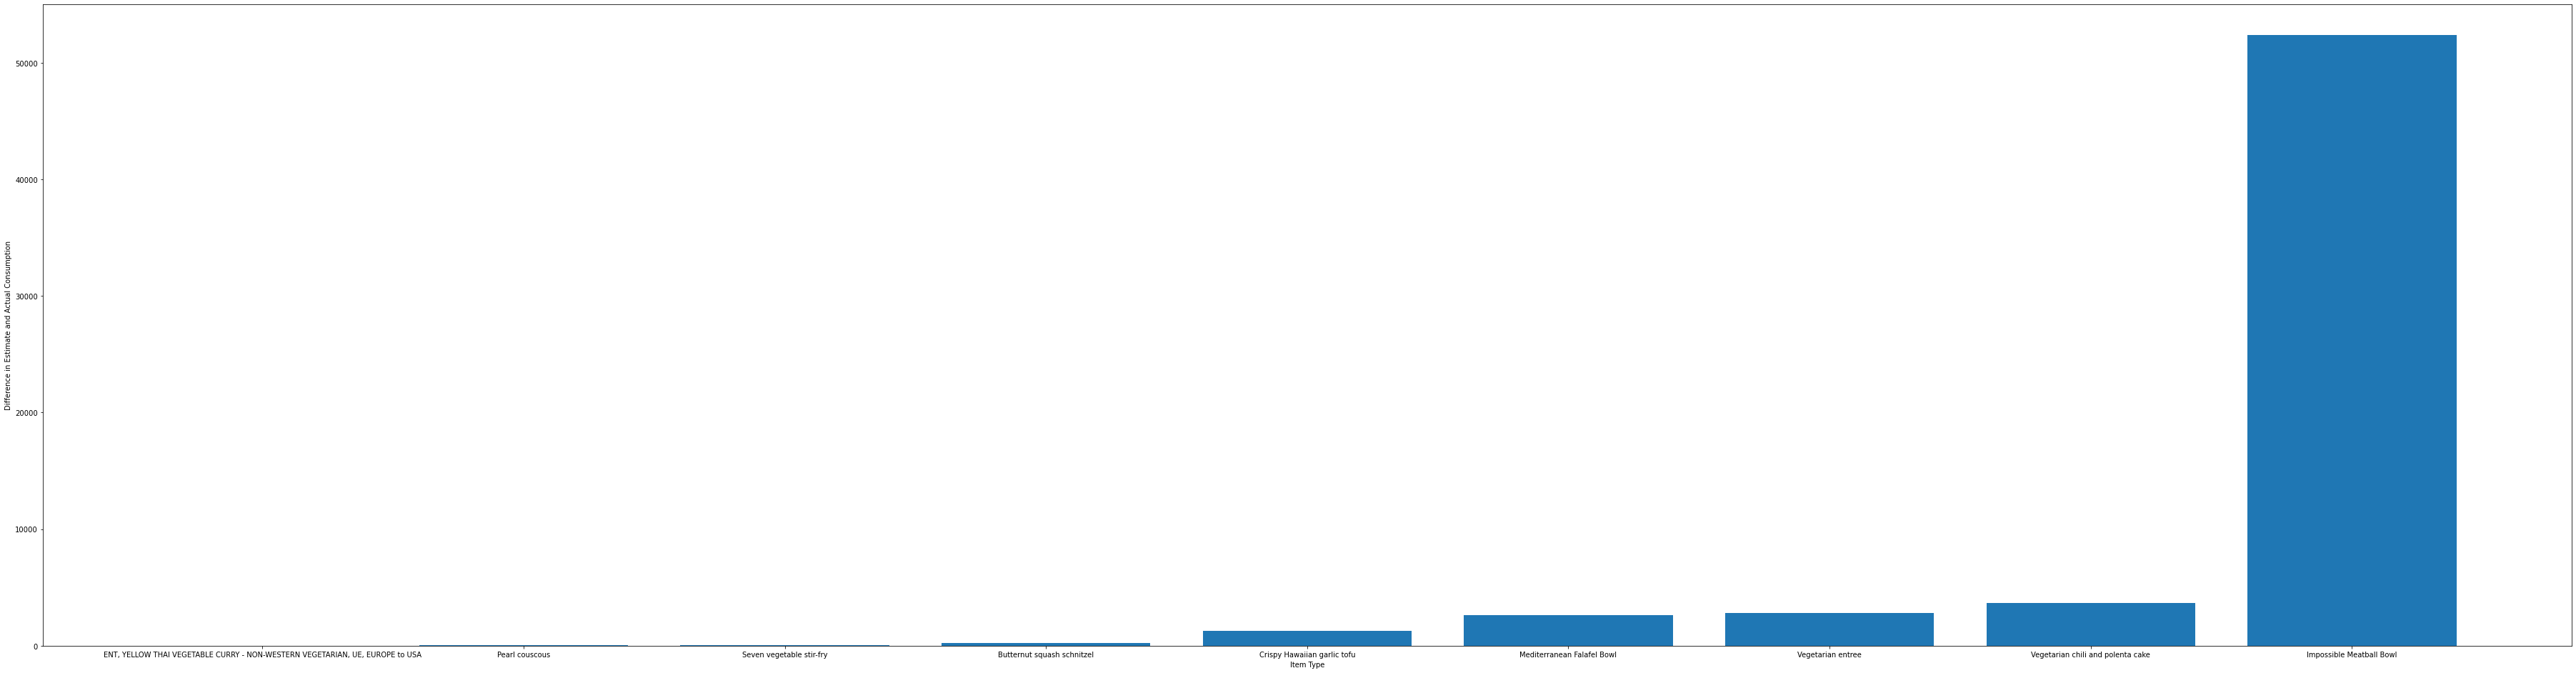

In [19]:
v_code_inventory=v_code_inventory.groupby('entree_description')['Difference'].sum().reset_index()
v_code_inventory = v_code_inventory.sort_values(by='Difference')
plt.figure(figsize=(50, 13))
plt.bar(v_code_inventory['entree_description'], v_code_inventory['Difference'])
plt.tight_layout()
plt.xlabel('Item Type')
plt.ylabel('Difference in Estimate and Actual Consumption')
plt.title('')
plt.show()

### - Another strategy that we can come up to reduce cost and maintain freshness of items is to reduce the quantity of Impossible Meat Bowl and Zatar Chicken on the flights and increase quantity of others.
### We shall now check if the age group, membership and national/international indicators cause any specific effect.

generation  satisfaction_type
Boomer      Dissatisfied         10408
            Satisfied             5959
Gen X       Dissatisfied          7126
            Satisfied             3962
Gen Z       Dissatisfied           495
            Satisfied              332
Greatest    Dissatisfied             2
Millennial  Dissatisfied          3244
            Satisfied             1735
NBK         Dissatisfied             2
            Satisfied                1
Silent      Dissatisfied          1076
            Satisfied              621
Name: count, dtype: int64


Text(0, 0.5, 'Count')

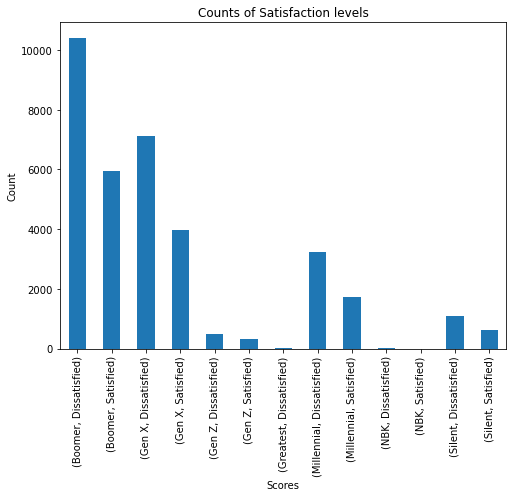

In [20]:
age_group = Total_satisfaction.groupby('generation')['satisfaction_type'].value_counts()
print(age_group)
plt.figure(figsize=(8, 6))
age_group.plot(kind='bar')
plt.title('Counts of Satisfaction levels')
plt.xlabel('Scores')
plt.ylabel('Count')

### As we can see the most reviews are in from the Boomer category, followed by Gen X and Millenial. 
### - Another fact to notice is that Boomers seem the most dissatisfied too. 

loyalty_program_level  satisfaction_type
NA                     Dissatisfied         5826
                       Satisfied            3555
NBK                    Dissatisfied            2
                       Satisfied               1
global services        Dissatisfied          389
                       Satisfied             178
non-elite              Dissatisfied         9362
                       Satisfied            5343
premier 1k             Dissatisfied         1880
                       Satisfied             936
premier gold           Dissatisfied         1547
                       Satisfied             790
premier platinum       Dissatisfied         1212
                       Satisfied             562
premier silver         Dissatisfied         2135
                       Satisfied            1245
Name: count, dtype: int64


Text(0, 0.5, 'Count')

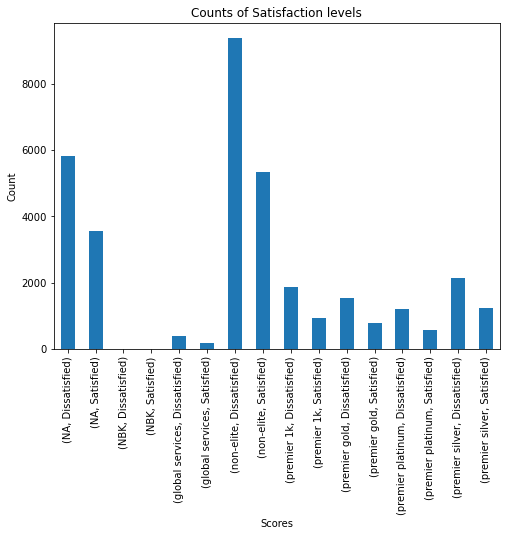

In [21]:
Total_satisfaction['loyalty_program_level'].fillna('NA', inplace=True)
membership = Total_satisfaction.groupby('loyalty_program_level')['satisfaction_type'].value_counts()
print(membership)
plt.figure(figsize=(8, 6))
membership.plot(kind='bar')
plt.title('Counts of Satisfaction levels')
plt.xlabel('Scores')
plt.ylabel('Count')

international_domestic_indicator  satisfaction_type
Domestic                          Dissatisfied         15039
                                  Satisfied             8814
International                     Dissatisfied          7314
                                  Satisfied             3796
Name: count, dtype: int64


Text(0, 0.5, 'Count')

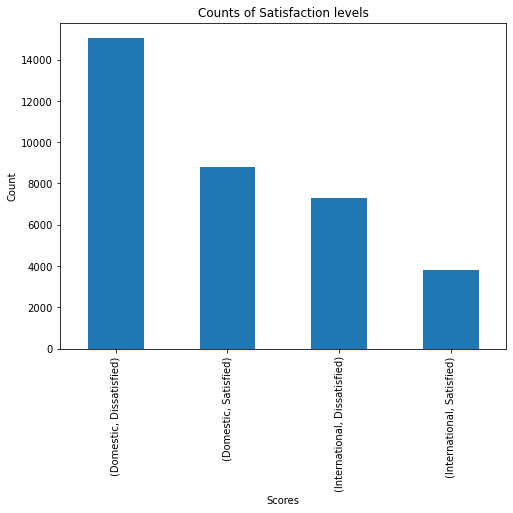

In [22]:
travel_type = Total_satisfaction.groupby('international_domestic_indicator')['satisfaction_type'].value_counts()
print(travel_type)
plt.figure(figsize=(8, 6))
travel_type.plot(kind='bar')
plt.title('Counts of Satisfaction levels')
plt.xlabel('Scores')
plt.ylabel('Count')

### - Domestic travellers are more satisfied at average than International travellers thus we might have to include more international food types based on destination and arrival airport. 
### - More attention needs to be paid to Premium Platinum travellers too as they are more experienced travellers with premium.We shall now focus on review centric improvements.

In [23]:
def sen_analy(sentence):
    score = analyser.polarity_scores(sentence)
    label='Neutral'
    if(score['neg']>0 and score['neg']>score['pos'] and score['compound']<0):
        label='Complaint'
        return label
    elif(score['pos']>0 and score['neg']<score['pos'] and score['compound']>0):
        label='Appreciation'
        return label
    else:
        return label

In [24]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                               u"\U0001F700-\U0001F77F"  # Alphabetic presentation forms
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-B
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U0001FB00-\U0001FBFF"  # Symbols for Legacy Computing
                               u"\U0001FC00-\U0001FCFF"  # Symbols for Legacy Computing
                               u"\U0001FD00-\U0001FDFF"  # Symbols for Legacy Computing
                               u"\U0001F700-\U0001F77F"  # Alphabetic presentation forms
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U0001FB00-\U0001FBFF"  # Symbols for Legacy Computing
                               u"\U0001FC00-\U0001FCFF"  # Symbols for Legacy Computing
                               u"\U0001FD00-\U0001FDFF"  # Symbols for Legacy Computing
                               u"\U0001F200-\U0001F251"  # Custom emoji
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [35]:
reviews=pd.read_csv('./Survey data _Customer comments.csv')
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")
positive_topics={}
negative_topics={}
topics={}
analyser = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))
for row_ind in range(len(reviews)):
    text=reviews.loc[row_ind,'verbatim_text']
    flag=0
    sentiment=sen_analy(text)
    if(sentiment=='Complaint'):
        flag=1
    elif(sentiment=='Appreciation'):
        flag=2
    else:
        flag=0
    text=text.lower()
    text=remove_emojis(text)
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)
    doc = nlp(clean_text)
    for phrase in doc._.phrases[:5]:
        freq_occ=['first','snack','snacks','flight','flights','one','food','something','everything']
        if(phrase.text in freq_occ):
            continue
        if(topics.get(phrase.text)!=None):
            topics[phrase.text]=topics[phrase.text]+1
        else:
            topics[phrase.text]=1
        if(flag==1):
            if(negative_topics.get(phrase.text)!=None):
                negative_topics[phrase.text]=negative_topics[phrase.text]+1
            else:
                negative_topics[phrase.text]=1
        if(flag==2):
            if(positive_topics.get(phrase.text)!=None):
                positive_topics[phrase.text]=positive_topics[phrase.text]+1
            else:
                positive_topics[phrase.text]=1

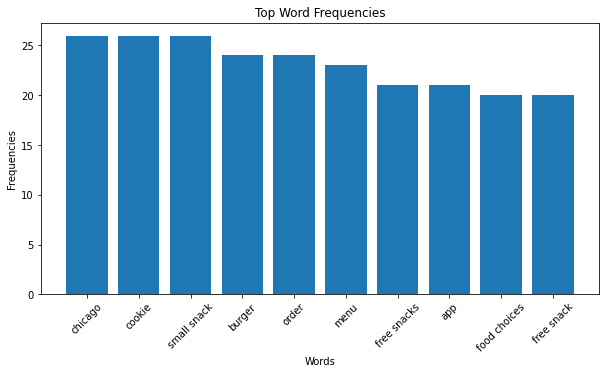

In [31]:
sorted_topic_freq = dict(sorted(topics.items(), key=lambda x: x[1], reverse=True)[50:60])
words = list(sorted_topic_freq.keys())
frequencies = list(sorted_topic_freq.values())
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.ylabel("Frequencies")
plt.title("Top Word Frequencies")
plt.xticks(rotation=45)
plt.show()

### We can go ahead and check for the top word frequencies, 10 at a time by changing the range above.
### We shall now try to analyse the positive and negative topics that have been generated.

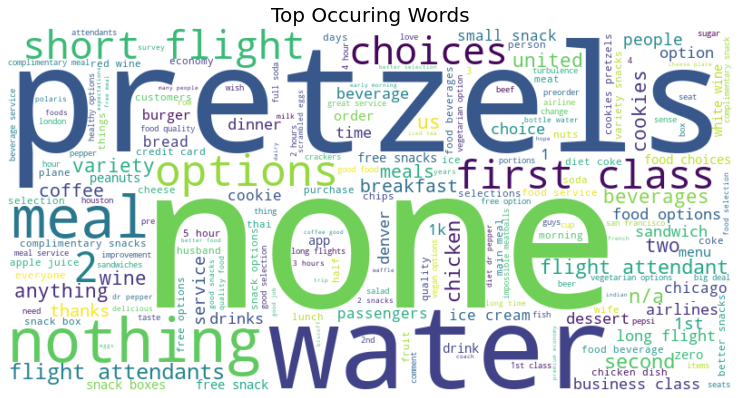

In [36]:
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(topics)
plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top Occuring Words',fontsize=20)
plt.show()

### We shall now analyse the negative topics and positive topics that we have figured out

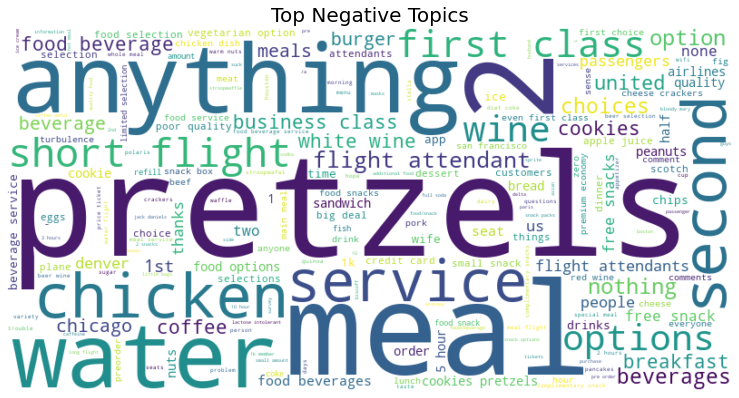

In [37]:
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(negative_topics)
plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top Negative Topics',fontsize=20)
plt.show()

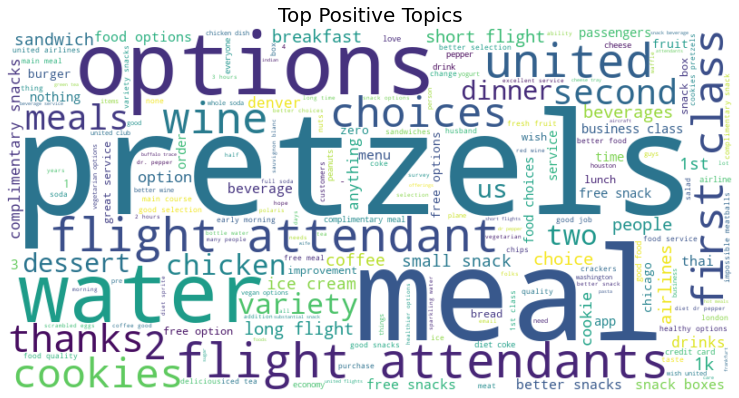

In [38]:
#We can do the same with appreciative topics too
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(positive_topics)
plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top Positive Topics',fontsize=20)
plt.show()

### Thus from the above word clouds we can induce some of the major issues that are being faced by the travellers as well as some of the points that are appreciated by them.